In [1]:
import numpy as np
import torch
import gym
from torch import nn
import matplotlib.pyplot as plt
from collections import deque

In [2]:
# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

In [3]:
# Actor module, categorical actions only
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, n_actions),
            nn.Softmax()
        )
    
    def forward(self, X):
        return self.model(X)

In [4]:
# Critic module
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, X):
        return self.model(X)

In [5]:
# Memory
# Stores results from the networks, instead of calculating the operations again from states, etc.
class Memory():
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

    def add(self, log_prob, value, reward, done):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear(self):
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.dones.clear()  
    
    def _zip(self):
        return zip(self.log_probs,
                self.values,
                self.rewards,
                self.dones)
    
    def __iter__(self):
        for data in self._zip():
            return data
    
    def reversed(self):
        for data in list(self._zip())[::-1]:
            yield data
    
    def __len__(self):
        return len(self.rewards)
        

In [6]:
env = gym.make("CartPole-v0")

In [7]:
# config
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99
memory = Memory()
max_steps = 200

In [8]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import wandb
wandb.login()

wandb: Currently logged in as: anjanav24. Use `wandb login --relogin` to force relogin


True

In [10]:
!wandb login

wandb: Currently logged in as: anjanav24. Use `wandb login --relogin` to force relogin


In [11]:
wandb.init(project="Cartpole", entity="anjanav24", config={"lr": 0.001, "num_episodes": 1500, "hidden_dim": 128, "batch_size": 64})

In [12]:
wandb.define_metric("episode")
wandb.define_metric("step")

wandb.define_metric("Actor_loss", step_metric="step")
wandb.define_metric("Critic_loss", step_metric="step")
wandb.define_metric("Episode_reward", step_metric="episode")
wandb.define_metric("Running_avg", step_metric="episode")

In [13]:
# train function
def train(memory, q_val):
    values = torch.stack(memory.values)
    q_vals = np.zeros((len(memory), 1))
    
    # target values are calculated backward
    # it's super important to handle correctly done states,
    # for those cases we want our to target to be equal to the reward only
    for i, (_, _, reward, done) in enumerate(memory.reversed()):
        q_val = reward + gamma*q_val*(1.0-done)
        q_vals[len(memory)-1 - i] = q_val # store values from the end to the beginning
        
    advantage = torch.Tensor(q_vals) - values
    
    critic_loss = advantage.pow(2).mean()
    c_loss = critic_loss.item()
    adam_critic.zero_grad()
    critic_loss.backward()
    adam_critic.step()
    
    actor_loss = (-torch.stack(memory.log_probs)*advantage.detach()).mean()
    a_loss = actor_loss.item()
    adam_actor.zero_grad()
    actor_loss.backward()
    adam_actor.step()

    return a_loss, c_loss

In [14]:
episode_rewards = []
running_avg_rewards = deque(maxlen=100)
running_rewards = []
ep_step = 0

for i in range(1500):
    done = False
    total_reward = 0
    state = env.reset()
    steps = 0

    while not done:
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        next_state, reward, done, info = env.step(action.detach().data.numpy())
        
        total_reward += reward
        steps += 1
        memory.add(dist.log_prob(action), critic(t(state)), reward, done)
        
        state = next_state
        
        # train if done or num steps > max_steps
        if done or (steps % max_steps == 0):
            last_q_val = critic(t(next_state)).detach().data.numpy()
            a_loss, c_loss = train(memory, last_q_val)
            log_loss = {"Actor_loss": a_loss, "Critic_loss": c_loss, "step": ep_step}
            wandb.log(log_loss)
            ep_step += 1
            memory.clear()
            r = -1 if done else reward
            
    episode_rewards.append(total_reward)
    running_avg_rewards.append(total_reward)
    running_rewards.append(np.mean(running_avg_rewards))

    log_rewards ={"Episode_reward": total_reward, "Running_avg": np.mean(running_avg_rewards), "episode": i}
    wandb.log(log_rewards)

    # Logs:
    if i%50 == 0:
      print(f"Episode: {i} | Reward: {total_reward} | Average reward: {np.mean(running_avg_rewards)}")

    # Termination condition
    if len(running_avg_rewards) == running_avg_rewards.maxlen:
      if np.mean(running_avg_rewards) >= 195.0:
        print(f"Environment solved in {i+1} episodes. Reward = {total_reward}")
        break


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode: 0 | Reward: 59.0 | Average reward: 59.0
Episode: 50 | Reward: 10.0 | Average reward: 17.019607843137255
Episode: 100 | Reward: 39.0 | Average reward: 18.92
Episode: 150 | Reward: 112.0 | Average reward: 48.22
Episode: 200 | Reward: 199.0 | Average reward: 133.63
Episode: 250 | Reward: 200.0 | Average reward: 189.61
Episode: 300 | Reward: 200.0 | Average reward: 187.65
Episode: 350 | Reward: 200.0 | Average reward: 192.0
Environment solved in 400 episodes. Reward = 200.0


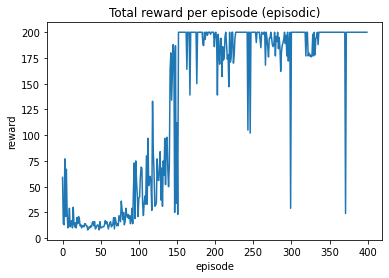

In [15]:
plt.plot(np.arange(len(episode_rewards)), episode_rewards)
plt.title("Total reward per episode (episodic)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

In [16]:
len(episode_rewards) == len(running_rewards)

True

In [17]:
import plotly.graph_objs as go
import plotly.io as pio

pio.templates.default = 'plotly_white'
cum_rewards = go.Scatter(x=np.arange(len(episode_rewards)), y=episode_rewards, mode='lines', name='Cumulative rewards', line=dict(color='rgb(242, 193, 189, 0.25)'))
avg_rewards = go.Scatter(x=np.arange(len(episode_rewards)), y=running_rewards, mode='lines', name='Running avg. rewards')

layout = go.Layout(title='Rewards for A2C agent (64 node) on CartPole-v0', xaxis_title='No. of episodes', yaxis_title='Rewards')
figure = go.Figure(data=[avg_rewards, cum_rewards], layout=layout)
config = {
        'toImageButtonOptions': {
            'format': 'png', # one of png, svg, jpeg, webp
            'height': 480,
            'width': 640,
            'scale': 2 # Multiply title/legend/axis/canvas sizes by this factor
        }
    }
figure.show(config=config)


In [18]:
import pickle
A2C_rewards_data = dict(cumulative_rewards=episode_rewards, running_avg_scores=running_rewards)
file = open("A2C_32.pkl", "wb")
pickle.dump(A2C_rewards_data, file)
file.close()

In [19]:
type(A2C_rewards_data['running_avg_scores'])

list

In [20]:
!mkdir A2C_128

In [21]:
torch.save(actor.state_dict(), '/content/A2C_128/actor_weights.pth')
torch.save(critic.state_dict(), '/content/A2C_128/critic_weights.pth')

In [22]:
# Test
actor.load_state_dict(torch.load('/content/A2C_128/actor_weights.pth'))

states = []
rewards = []
done = False
state = env.reset()
total_reward = 0

while not done:
  probs = actor(t(state))
  dist = torch.distributions.Categorical(probs=probs)
  action = dist.sample()
        
  next_state, reward, done, info = env.step(action.detach().data.numpy())
        
  total_reward += reward
  steps += 1
  states.append(state)

  if done:
    reward = -1
    break

  
  state = next_state

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



In [23]:
states

[array([ 0.00300311,  0.0006123 , -0.00590529, -0.03806704]),
 array([ 0.00301535,  0.19581843, -0.00666663, -0.33260728]),
 array([ 0.00693172,  0.000792  , -0.01331878, -0.04203412]),
 array([ 0.00694756,  0.19610238, -0.01415946, -0.33888931]),
 array([ 0.01086961,  0.39142292, -0.02093725, -0.63600349]),
 array([ 0.01869807,  0.19659914, -0.03365732, -0.34998697]),
 array([ 0.02263005,  0.00197162, -0.04065706, -0.06810442]),
 array([ 0.02266948,  0.19765218, -0.04201915, -0.37333257]),
 array([ 0.02662253,  0.00315153, -0.0494858 , -0.09418912]),
 array([ 0.02668556,  0.19894654, -0.05136958, -0.40206499]),
 array([ 0.03066449,  0.00458941, -0.05941088, -0.12600988]),
 array([ 0.03075628, -0.18963333, -0.06193108,  0.14735369]),
 array([ 0.02696361,  0.0063183 , -0.058984  , -0.16420636]),
 array([ 0.02708997, -0.18791185, -0.06226813,  0.10930097]),
 array([ 0.02333174, -0.3820888 , -0.06008211,  0.38170691]),
 array([ 0.01568996, -0.18616748, -0.05244797,  0.07070169]),
 array([

In [24]:
states = np.array(states)
states.shape

(200, 4)

Text(0.5, 1.0, 'Position using trained A2C128 agent')

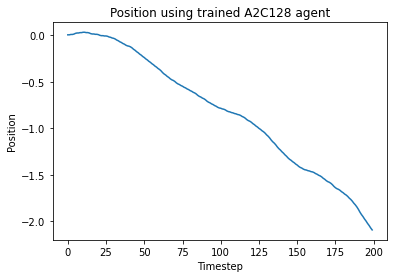

In [25]:
plt.plot(states[:, 0])
plt.xlabel("Timestep")
plt.ylabel("Position")
plt.title("Position using trained A2C128 agent")

Text(0.5, 1.0, 'Angular position using trained A2C128 agent')

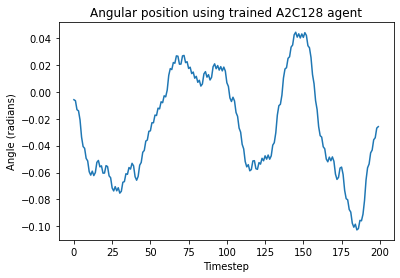

In [26]:
plt.plot(states[:, 2])
plt.xlabel("Timestep")
plt.ylabel("Angle (radians)")
plt.title("Angular position using trained A2C128 agent")

In [27]:
file = open("Test_state_128.pkl", "wb")
pickle.dump(states, file)
file.close()